In [15]:
import os
import platform
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import pandas as pd
from utils import general_process

from pymoo.core.problem import Problem, ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.problems import get_problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set_context('notebook')
sns.set_theme(style="ticks", palette="bright")
plt.style.use(['grid'])

if platform.system() == 'Windows':
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
else:  # Mac or other systems
    plt.rcParams['font.family'] = ['Arial Unicode MS']

# load lightGBM model
with open('model_and_encoders2.pkl', 'rb') as f:
    loaded_data = pickle.load(f)
model = loaded_data['model']
label_encoders = loaded_data['label_encoders']

# preprocess and load data
filepath = 'train_data.pkl'
if not os.path.exists(filepath):
    general_process(output_filepath=filepath)
with open(filepath, 'rb') as fin:
    df = pickle.load(fin)
# compute 'flux_density_max'
df['flux_density_max'] = df['flux_density'].apply(lambda r: np.max(r))
df

,type_material,temp,freq,core_loss,type_waveform,flux_density,flux_density_max
0,1,25,50030,1997.955250,正弦波,"[0.000212759, 0.000389496, 0.00056608, 0.00074...",0.028849
1,1,25,50020,2427.749830,正弦波,"[-0.000550883, -0.000357918, -0.000165251, 2.7...",0.031419
2,1,25,50020,3332.725760,正弦波,"[-0.003779509, -0.003563773, -0.003348945, -0....",0.035535
3,1,25,50020,4502.908007,正弦波,"[-0.000510932, -0.000266662, -2.25e-05, 0.0002...",0.040015
4,1,25,50030,6063.023248,正弦波,"[0.000457688, 0.000732427, 0.00100655, 0.00128...",0.045028
...,...,...,...,...,...,...,...
12395,4,90,199190,20604.900210,梯形波,"[-0.017758287, -0.017339198, -0.016932051, -0....",0.034867
12396,4,90,199190,26504.284280,梯形波,"[-0.019690471, -0.019226928, -0.018775593, -0....",0.038341
12397,4,90,199190,46232.491530,梯形波,"[-0.024998103, -0.024410702, -0.02383819, -0.0...",0.048877
12398,4,90,199190,61458.085900,梯形波,"[-0.027987528, -0.027328599, -0.026686789, -0....",0.054889


In [16]:
df.drop_duplicates(subset=['freq', 'flux_density_max', 'temp', 'type_material', 'type_waveform', 'core_loss'], inplace=True)
df

,type_material,temp,freq,core_loss,type_waveform,flux_density,flux_density_max
0,1,25,50030,1997.955250,正弦波,"[0.000212759, 0.000389496, 0.00056608, 0.00074...",0.028849
1,1,25,50020,2427.749830,正弦波,"[-0.000550883, -0.000357918, -0.000165251, 2.7...",0.031419
2,1,25,50020,3332.725760,正弦波,"[-0.003779509, -0.003563773, -0.003348945, -0....",0.035535
3,1,25,50020,4502.908007,正弦波,"[-0.000510932, -0.000266662, -2.25e-05, 0.0002...",0.040015
4,1,25,50030,6063.023248,正弦波,"[0.000457688, 0.000732427, 0.00100655, 0.00128...",0.045028
...,...,...,...,...,...,...,...
12395,4,90,199190,20604.900210,梯形波,"[-0.017758287, -0.017339198, -0.016932051, -0....",0.034867
12396,4,90,199190,26504.284280,梯形波,"[-0.019690471, -0.019226928, -0.018775593, -0....",0.038341
12397,4,90,199190,46232.491530,梯形波,"[-0.024998103, -0.024410702, -0.02383819, -0.0...",0.048877
12398,4,90,199190,61458.085900,梯形波,"[-0.027987528, -0.027328599, -0.026686789, -0....",0.054889


In [5]:
demo = np.array([label_encoders['type_material'].transform(['1'])[0],
                 25, 50020,
                 label_encoders['type_waveform'].transform(['正弦波'])[0], 0.031419])
demo = demo.reshape(1, -1)
model.predict(demo)

array([2187.34254979])

In [33]:
df['temp'].unique()

array([25, 50, 70, 90])

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       50 |     16 |             - |             -
     2 |      100 |     22 |  0.0089205416 |         nadir
     3 |      150 |     31 |  0.0857980340 |         ideal
     4 |      200 |     36 |  0.0729413341 |         ideal
     5 |      250 |     47 |  0.0112127150 |         ideal
     6 |      300 |     50 |  0.0050873304 |             f
     7 |      350 |     50 |  0.0048470668 |         ideal
     8 |      400 |     50 |  0.0341818205 |         ideal
     9 |      450 |     50 |  0.0006508639 |             f
    10 |      500 |     50 |  0.0016517193 |             f
    11 |      550 |     50 |  0.0035521172 |             f
    12 |      600 |     48 |  0.0045043986 |         ideal
    13 |      650 |     49 |  0.0007438277 |             f
    14 |      700 |     50 |  0.0012380804 |             f
    15 |      750 |     50 |  0.0014716927 |             f
    16 |      800 |     50 |  0.0026952596 |         ide

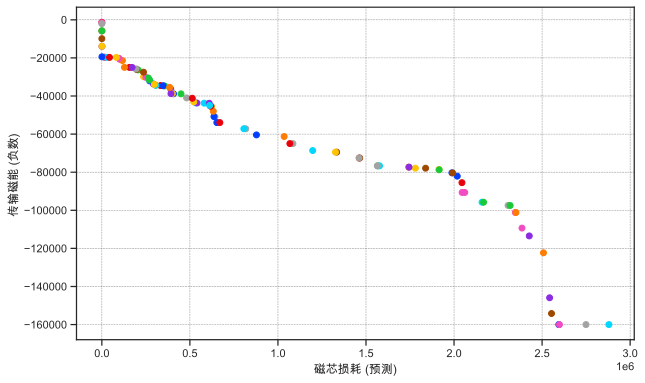

In [17]:
def f(x, type_material, type_waveform, temp):
    """ 磁芯损耗 """
    freq, flux_density_max = x

    X = np.array([
        label_encoders['type_material'].transform([type_material])[0],
        temp, freq,
        label_encoders['type_waveform'].transform([type_waveform])[0],
        flux_density_max])
    X = X.reshape(1, -1)
    core_loss = model.predict(X)
    # 异常值
    if core_loss[0] < 0:
        return 361613200
    return core_loss[0]


def g(x):
    """ 传输磁能 """
    freq, flux_density_max = x
    return freq * flux_density_max


class MyProblem(ElementwiseProblem):
    def __init__(self, type_material, type_waveform, temp):
        super().__init__(n_var=2, n_obj=2,
                         xl=np.array([5e4, 0.009]),
                         xu=np.array([5e5, 0.32]))
        self.type_material = type_material
        self.type_waveform = type_waveform
        self.temp = temp

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = [f(x, self.type_material, self.type_waveform, self.temp), -g(x)]

materials = ['1', '2', '3', '4']
waveforms = ['正弦波', '三角波', '梯形波']
temperatures = [25, 50, 70, 90]
all_pareto_fronts = []
all_x_values = []

for material in materials:
    for waveform in waveforms:
        for temp in temperatures:
            problem = MyProblem(material, waveform, temp)
            algorithm = NSGA2(pop_size=50)
            res = minimize(problem,
                           algorithm,
                           ('n_gen', 200),
                           seed=1,
                           verbose=True)
            all_pareto_fronts.append(res.F)
            for x in res.X:
                all_x_values.append([material, waveform, temp, *x, f(x, material, waveform, temp), g(x)])

# concatenate all pareto fronts
all_pareto_fronts = np.concatenate(all_pareto_fronts, axis=0)

# perform non-dominated sorting
nds = NonDominatedSorting()
pareto_front_indices = nds.do(all_pareto_fronts, only_non_dominated_front=True)
pareto_front = all_pareto_fronts[pareto_front_indices]
pareto_x_values = [all_x_values[i] for i in pareto_front_indices]

[1, 15, 27, 36, 47, 56, 65, 77, 86, 95]


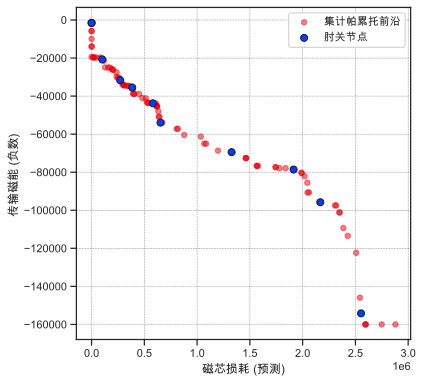

In [73]:
def break_counter(sequence, step=25, eps=0.05, verbose=False):
    """ count the number of the "change" 
    of the first_derivative is bigger than eps """
    first_derivative = np.diff(sequence[::step])
    pivots = []
    for j in range(len(first_derivative) - 1):
        if np.abs(first_derivative[j+1] - first_derivative[j]) > eps:
            if not pivots or j - pivots[-1] > 8:
                pivots.append(j)
    if verbose:
        print(pivots)
    return pivots

plt.figure(figsize=(6, 6))
for i, (material, waveform, temp, freq, flux_density_max, core_loss, trans_energy) in enumerate(pareto_x_values):
    if i == 0:
        plt.scatter(core_loss, -trans_energy, color=f'C{3}', s=30, alpha=0.5, label='集计帕累托前沿')
    plt.scatter(core_loss, -trans_energy, color=f'C{3}', s=30, alpha=0.5)

# sort pareto_x_values by core_loss
pareto_x_values_sorted = sorted(pareto_x_values, key=lambda x: x[5])

# calculate elbow points in the pareto front using sorted trans_energy
trans_energies_sorted = [x[6] for x in pareto_x_values_sorted]
elbow_points = break_counter(trans_energies_sorted, step=1, eps=1000, verbose=True)

# highlight elbow points
for i, idx in enumerate(elbow_points):
    core_loss, trans_energy = pareto_x_values_sorted[idx][5], pareto_x_values_sorted[idx][6]
    if i == 0:
        plt.scatter(core_loss, -trans_energy, color='C0', s=50, edgecolor='k', label = '肘关节点')
    plt.scatter(core_loss, -trans_energy, color='C0', s=50, edgecolor='k')

assert len(pareto_x_values) == len(pareto_front)
# set axis labels and show plot
plt.xlabel('磁芯损耗 (预测)')
plt.ylabel('传输磁能 (负数) ')
plt.legend()
plt.savefig('figures/p5-pareto.pdf', bbox_inches='tight')

# save x values and corresponding f(x) and g(x) to csv
df = pd.DataFrame(pareto_x_values, columns=['材料', '波形', '温度', '频率', '磁通密度峰值', '磁芯损耗', '传输磁能'])
df.to_csv('pareto_data.csv', index=False)

In [75]:
# create latex table for elbow points
elbow_df = pd.DataFrame([pareto_x_values_sorted[idx] for idx in elbow_points],
                        columns=['材料', '波形', '温度', '频率', '磁通密度峰值', '磁芯损耗', '传输磁能'])
elbow_latex = elbow_df.to_latex(index=False, header=True, float_format="%.6f")
print(elbow_latex)

\begin{tabular}{llrrrrr}
\toprule
材料 & 波形 & 温度 & 频率 & 磁通密度峰值 & 磁芯损耗 & 传输磁能 \\
\midrule
3 & 三角波 & 90 & 62500.048511 & 0.024357 & 8.697637 & 1522.313720 \\
1 & 三角波 & 70 & 421910.606170 & 0.049117 & 101262.657082 & 20723.055496 \\
1 & 梯形波 & 70 & 418222.818423 & 0.075541 & 270887.433787 & 31592.919582 \\
1 & 梯形波 & 90 & 408047.778776 & 0.086896 & 385167.479167 & 35457.601652 \\
1 & 三角波 & 90 & 445900.889577 & 0.098154 & 581040.747386 & 43767.112965 \\
1 & 三角波 & 90 & 446377.600224 & 0.120841 & 652958.200327 & 53940.663756 \\
1 & 梯形波 & 90 & 499964.448780 & 0.138940 & 1326630.628681 & 69465.199678 \\
1 & 三角波 & 70 & 499999.799733 & 0.157187 & 1914461.008334 & 78593.407110 \\
1 & 正弦波 & 70 & 499999.990939 & 0.191534 & 2167647.100085 & 95766.758596 \\
1 & 梯形波 & 70 & 499999.999131 & 0.308381 & 2553538.945165 & 154190.655778 \\
\bottomrule
\end{tabular}



In [76]:
print(df.to_latex(index=False, header=True, float_format="%.2f"))


\begin{tabular}{llrrrrr}
\toprule
材料 & 波形 & 温度 & 频率 & 磁通密度峰值 & 磁芯损耗 & 传输磁能 \\
\midrule
1 & 正弦波 & 70 & 500000.00 & 0.32 & 2594827.00 & 160000.00 \\
1 & 正弦波 & 70 & 396781.14 & 0.31 & 2507796.26 & 122330.34 \\
1 & 正弦波 & 70 & 499964.62 & 0.15 & 1566117.94 & 76668.66 \\
1 & 正弦波 & 70 & 473221.99 & 0.15 & 1461993.98 & 72567.63 \\
1 & 正弦波 & 70 & 354557.26 & 0.32 & 2427148.07 & 113458.32 \\
1 & 正弦波 & 70 & 499964.04 & 0.14 & 1333410.55 & 69471.31 \\
1 & 正弦波 & 70 & 354569.30 & 0.31 & 2385860.01 & 109341.45 \\
1 & 正弦波 & 70 & 473302.40 & 0.14 & 1085231.18 & 64986.53 \\
1 & 正弦波 & 70 & 397280.68 & 0.08 & 237012.39 & 29916.32 \\
1 & 正弦波 & 70 & 499972.55 & 0.19 & 2158830.09 & 95761.50 \\
1 & 正弦波 & 70 & 446265.96 & 0.09 & 406849.41 & 38841.09 \\
1 & 正弦波 & 70 & 375759.40 & 0.12 & 622242.92 & 45402.77 \\
1 & 正弦波 & 70 & 499999.99 & 0.19 & 2167647.10 & 95766.76 \\
1 & 正弦波 & 70 & 446051.57 & 0.08 & 333646.02 & 34521.63 \\
1 & 正弦波 & 70 & 445851.95 & 0.08 & 292946.36 & 33685.41 \\
1 & 正弦波 & 90 & 473324.11 & 0.